In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import STL
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, awesome_oscillator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
import warnings
warnings.filterwarnings('ignore')

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


Bad key "text.kerning_factor" on line 4 in
C:\Users\victo\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def plot_ohlc(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Ohlc(x=df.index,
                          open=df.Open,
                          high=df.High,
                          low=df.Low,
                          close=df.Close,
                          name='Price'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df.index, y=df.Volume, name='Volume'), row=2, col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

def plot_decomposed_close_data(df):
    data = azn_df[['Close']].copy()
    res = STL(data, period=365).fit()
    fig = res.plot()
    fig.set_size_inches(20, 8)
    
def plot_moving_averages(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df.EMA_200, name='EMA 200'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_5, name='SMA 5'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_10, name='SMA 10'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_30, name='SMA 30'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_100, name='SMA 100'))
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close', opacity=0.2))
    fig.show()
    
def plot_RSI(df):
    fig = go.Figure(go.Scatter(x=df.index, y=df.RSI, name='RSI'))
    fig.show()
    
def plot_MACD(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD Signal'], name='Signal line'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close'), row=2, col=1)
    fig.show()
    
#def plot_train_test_data(train_df, valid_df, test_df):
 #   fig = go.Figure()
  #  fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
   # fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
    #fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
     #fig.show()
    
def plot_predictions(predicted_prices, df, column):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df[column],
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices[column],
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def plot_high_low_predictions(predicted_prices, df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.High,
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices.High,
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def get_moving_averages(df):
    df_sma = SMAIndicator(close=df['Close'], window=5)
    df['SMA_5'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=10)
    df['SMA_10'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=30)
    df['SMA_30'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=100)
    df['SMA_100'] = df_sma.sma_indicator()
    df_ema = EMAIndicator(close=df['Close'], window=200)
    df['EMA_200'] = df_ema.ema_indicator()
    df.dropna(inplace=True)
    
def get_RSI(df):
    df_rsi = RSIIndicator(close=df['Close'], window=14)
    df['RSI'] = df_rsi.rsi()
    df.dropna(inplace=True)
    
def get_MACD(df):
    macd = MACD(close=df['Close'])
    df['MACD'] = macd.macd()
    df['MACD Signal'] = macd.macd_signal()
    df.dropna(inplace=True)

In [3]:
start = dt.datetime(2010,1,1)
end = dt.datetime.now()
tickers = ['PFE', 'MRNA', 'JNJ', 'AZN']

filenames = []

for ticker in tickers:
    if ticker == 'MRNA':
        df = yf.download(ticker, dt.datetime(2018,12,7), end)
    else:
        df = yf.download(ticker, start, end)
    filename = f'{ticker}_stock_prices.csv'
    filenames.append(filename)
    df.to_csv(filename)
    
for filename in filenames:
    if filename.startswith('AZN'):
        azn_df = pd.read_csv('AZN_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('MRNA'):
        mrna_df = pd.read_csv('MRNA_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('JNJ'):
        jnj_df = pd.read_csv('JNJ_stock_prices.csv', index_col='Date', parse_dates=True)
    else:
        pfe_df = pd.read_csv('PFE_stock_prices.csv', index_col='Date', parse_dates=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
azn_df.head()

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2010-01-04  23.709999  23.764999  23.575001  23.705000  13.959425  2606200
2010-01-05  23.434999  23.465000  23.150000  23.225000  13.676762  2666600
2010-01-06  22.915001  23.045000  22.785000  23.040001  13.567821  3020800
2010-01-07  23.250000  23.325001  23.120001  23.290001  13.715042  4454600
2010-01-08  23.270000  23.415001  23.174999  23.389999  13.773925  2675600

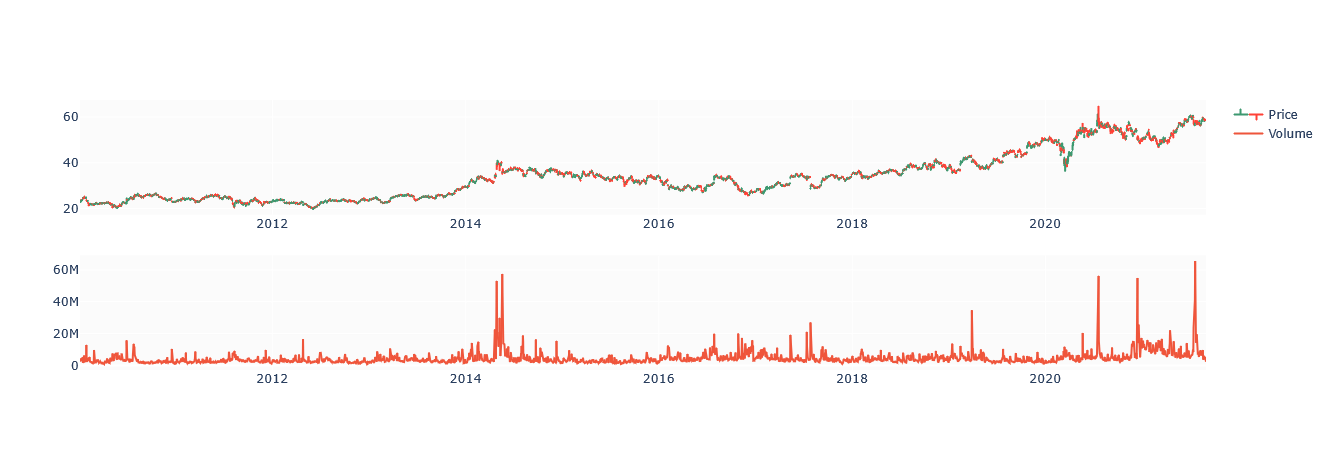

In [5]:
# Get OHLC chart for AZN

plot_ohlc(azn_df)

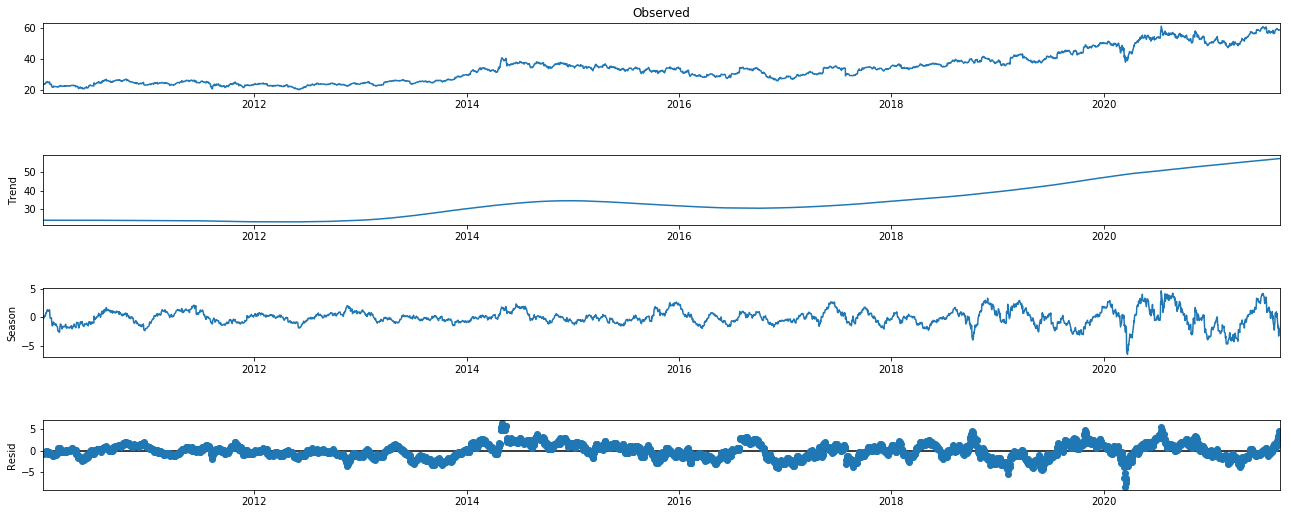

In [6]:
# Decomposing close price for AZN

plot_decomposed_close_data(azn_df)

In [7]:
# Adding Moving Averages for AZN

get_moving_averages(azn_df)
azn_df.head()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                      
2010-10-18  26.615  26.750000  26.575001  26.750000  16.571011  1316800   
2010-10-19  26.045  26.205000  25.735001  25.875000  16.028967  2565200   
2010-10-20  26.035  26.455000  26.025000  26.385000  16.344898  2072600   
2010-10-21  26.135  26.170000  25.830000  26.055000  16.140471  2281000   
2010-10-22  25.775  26.120001  25.745001  26.059999  16.143570  2592000   

                SMA_5   SMA_10     SMA_30   SMA_100    EMA_200  
Date                                                            
2010-10-18  26.543999  26.2530  26.017667  24.69040  24.216068  
2010-10-19  26.459000  26.2580  26.030000  24.73990  24.232575  
2010-10-20  26.447000  26.3220  26.054833  24.79250  24.253992  
2010-10-21  26.332000  26.3325  26.066167  24.84150  24.271913  
2010-10-22  26.225000  26.3265  26.071833  24.88415  24.289704

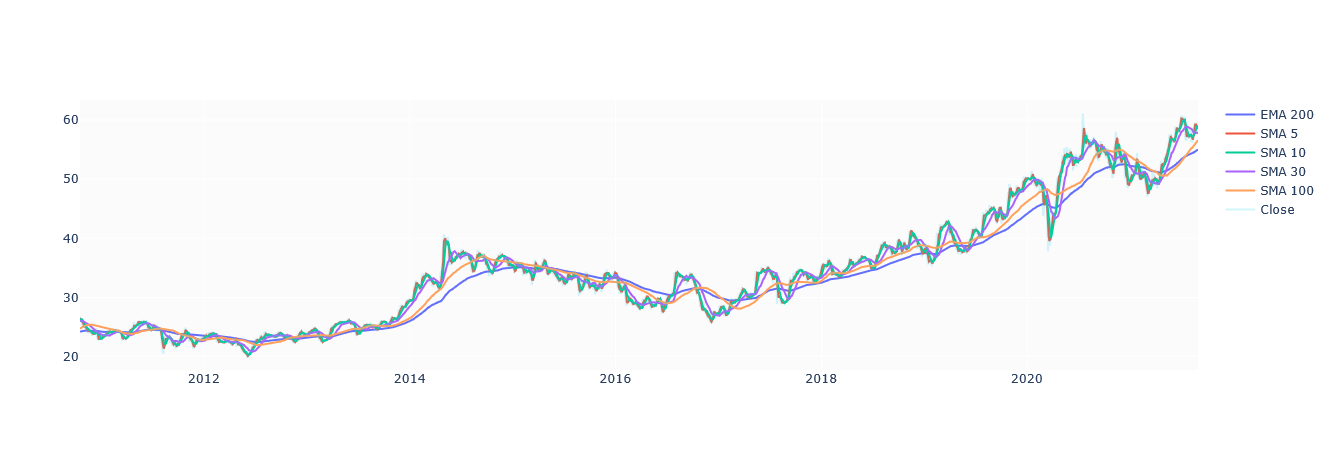

In [8]:
# Plotting Moving Averages for AZN

plot_moving_averages(azn_df)

In [9]:
# Adding RSI Indicator

get_RSI(azn_df)
azn_df.head()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2010-11-04  25.264999  25.344999  24.910000  25.025000  15.502411  3131400   
2010-11-05  25.150000  25.150000  24.934999  25.049999  15.517898  2136200   
2010-11-08  24.895000  24.934999  24.820000  24.844999  15.390899  1447200   
2010-11-09  25.045000  25.110001  24.709999  24.780001  15.350637  1616800   
2010-11-10  24.730000  24.795000  24.510000  24.790001  15.356835  1734200   

             SMA_5   SMA_10     SMA_30   SMA_100    EMA_200        RSI  
Date                                                                    
2010-11-04  25.105  25.4245  25.845833  25.19950  24.380607  22.504361  
2010-11-05  25.069  25.3235  25.802667  25.22110  24.387267  23.631404  
2010-11-08  25.043  25.2055  25.763500  25.24060  24.391822  20.941833  
2010-11-09  24.974  25.0880  25.722500  25.26095  24.395684  20.158430  
2010-11-10  24.898  25.0205  25.695167  25.28450  24.399608  20.650251

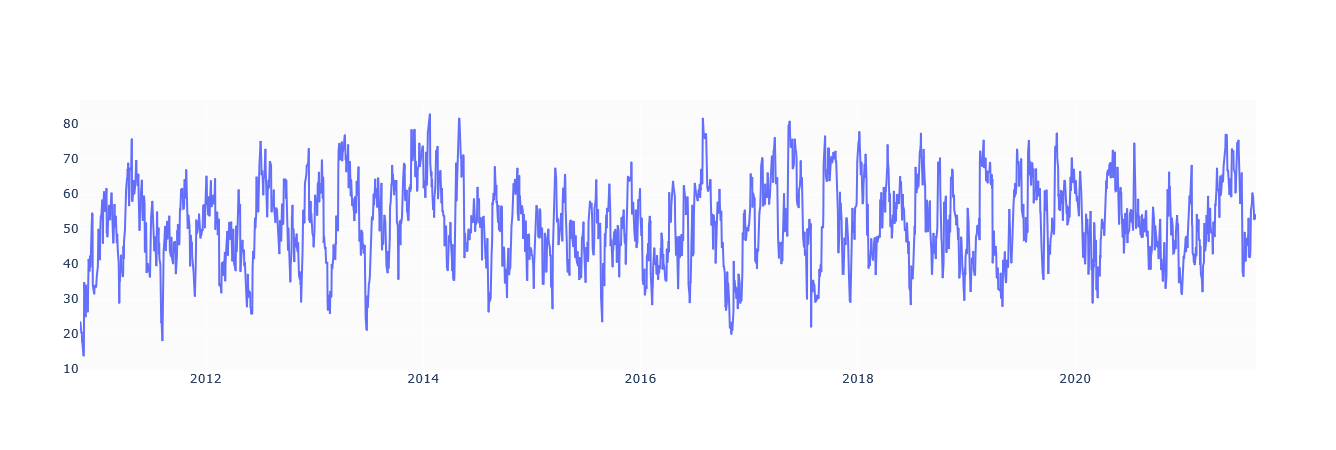

In [10]:
# Plotting RSI 

plot_RSI(azn_df)

In [11]:
# Adding MACD and MACD Signal Values

get_MACD(azn_df)
azn_df.head()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2010-12-22  22.834999  22.900000  22.795000  22.900000  14.186022  1168000   
2010-12-23  22.975000  23.125000  22.959999  23.014999  14.257259  1939400   
2010-12-27  23.010000  23.040001  22.950001  23.014999  14.257259  1029200   
2010-12-28  23.014999  23.030001  22.870001  22.969999  14.229385  1023400   
2010-12-29  22.959999  23.155001  22.955000  23.090000  14.303723  2181600   

                SMA_5  SMA_10     SMA_30   SMA_100    EMA_200        RSI  \
Date                                                                       
2010-12-22  23.328000  23.798  24.027833  25.21725  24.293954  31.319265   
2010-12-23  23.008000  23.716  23.968667  25.18610  24.281228  33.792616   
2010-12-27  22.973000  23.628  23.917667  25.15925  24.268628  33.792616   
2010-12-28  22.971999  23.486  23.866000  25.12900  24.255707  33.249218   
2010-12-29  22.998000  23.337  23.828167  25.09840  24.244108  36.195687   

                MACD  MACD Signal  
Date                               
2010-12-22 -0.307806    -0.195181  
2010-12-23 -0.335265    -0.223198  
2010-12-27 -0.352957    -0.249150  
2010-12-28 -0.366386    -0.272597  
2010-12-29 -0.363159    -0.290709

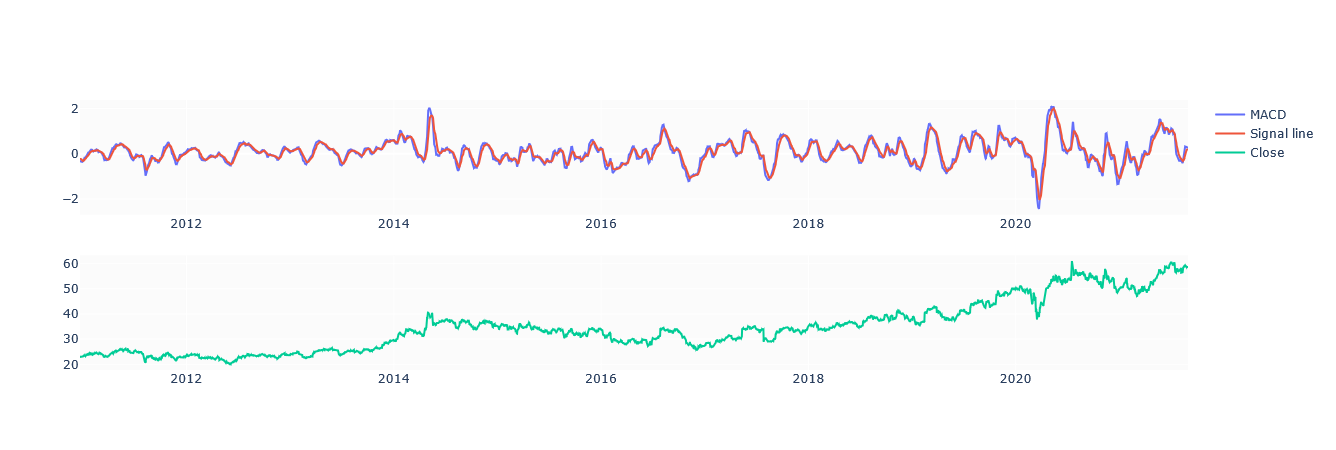

In [12]:
# Plottig MACD

plot_MACD(azn_df)

In [13]:
azn_df['Close'] = azn_df['Close'].shift(-1)
azn_df.head()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2010-12-22  22.834999  22.900000  22.795000  23.014999  14.186022  1168000   
2010-12-23  22.975000  23.125000  22.959999  23.014999  14.257259  1939400   
2010-12-27  23.010000  23.040001  22.950001  22.969999  14.257259  1029200   
2010-12-28  23.014999  23.030001  22.870001  23.090000  14.229385  1023400   
2010-12-29  22.959999  23.155001  22.955000  23.030001  14.303723  2181600   

                SMA_5  SMA_10     SMA_30   SMA_100    EMA_200        RSI  \
Date                                                                       
2010-12-22  23.328000  23.798  24.027833  25.21725  24.293954  31.319265   
2010-12-23  23.008000  23.716  23.968667  25.18610  24.281228  33.792616   
2010-12-27  22.973000  23.628  23.917667  25.15925  24.268628  33.792616   
2010-12-28  22.971999  23.486  23.866000  25.12900  24.255707  33.249218   
2010-12-29  22.998000  23.337  23.828167  25.09840  24.244108  36.195687   

                MACD  MACD Signal  
Date                               
2010-12-22 -0.307806    -0.195181  
2010-12-23 -0.335265    -0.223198  
2010-12-27 -0.352957    -0.249150  
2010-12-28 -0.366386    -0.272597  
2010-12-29 -0.363159    -0.290709

In [14]:
azn_df.tail()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2021-08-24  58.360001  58.570000  57.860001  58.580002  58.520000  4234000   
2021-08-25  58.939999  58.950001  58.400002  58.759998  58.580002  5606800   
2021-08-26  58.860001  59.060001  58.430000  58.630001  58.759998  3715400   
2021-08-27  58.889999  59.230000  58.459999  58.610001  58.630001  5244600   
2021-08-30  58.669998  58.805000  58.514999        NaN  58.610001  2296705   

                SMA_5     SMA_10     SMA_30  SMA_100    EMA_200        RSI  \
Date                                                                         
2021-08-24  59.067999  58.598999  57.781000  56.2065  54.803345  52.588418   
2021-08-25  58.896000  58.796000  57.740333  56.2970  54.840923  53.023886   
2021-08-26  58.810000  58.925999  57.800333  56.3924  54.879919  54.377634   
2021-08-27  58.658000  58.941000  57.861667  56.4945  54.917233  53.185544   
2021-08-30  58.620000  58.927000  57.932667  56.5856  54.953977  52.993058   

                MACD  MACD Signal  
Date                               
2021-08-24  0.299113     0.123649  
2021-08-25  0.283639     0.155647  
2021-08-26  0.282642     0.181046  
2021-08-27  0.268269     0.198490  
2021-08-30  0.252356     0.209264

In [15]:
# Dropping the last row NaN

azn_df = azn_df[:-1]
azn_df.tail()

Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2021-08-23  59.090000  59.349998  58.779999  58.520000  58.799999  6114700   
2021-08-24  58.360001  58.570000  57.860001  58.580002  58.520000  4234000   
2021-08-25  58.939999  58.950001  58.400002  58.759998  58.580002  5606800   
2021-08-26  58.860001  59.060001  58.430000  58.630001  58.759998  3715400   
2021-08-27  58.889999  59.230000  58.459999  58.610001  58.630001  5244600   

                SMA_5     SMA_10     SMA_30  SMA_100    EMA_200        RSI  \
Date                                                                         
2021-08-23  59.233999  58.387999  57.850667  56.1166  54.765991  54.789241   
2021-08-24  59.067999  58.598999  57.781000  56.2065  54.803345  52.588418   
2021-08-25  58.896000  58.796000  57.740333  56.2970  54.840923  53.023886   
2021-08-26  58.810000  58.925999  57.800333  56.3924  54.879919  54.377634   
2021-08-27  58.658000  58.941000  57.861667  56.4945  54.917233  53.185544   

                MACD  MACD Signal  
Date                               
2021-08-23  0.320621     0.079783  
2021-08-24  0.299113     0.123649  
2021-08-25  0.283639     0.155647  
2021-08-26  0.282642     0.181046  
2021-08-27  0.268269     0.198490

In [16]:
df_train, df_test = train_test_split(azn_df, train_size=0.9, shuffle=False)

In [17]:
x_train = df_train.drop('Close', axis=1)
y_train = df_train[['Close']]
x_test = df_test.drop('Close', axis=1)
y_test = df_test[['Close']]

In [18]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [19]:
model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
y_pred = model.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.002941183169057547


In [21]:
predicted_prices = azn_df.loc[df_test.index[0]:].copy()
predicted_prices['Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

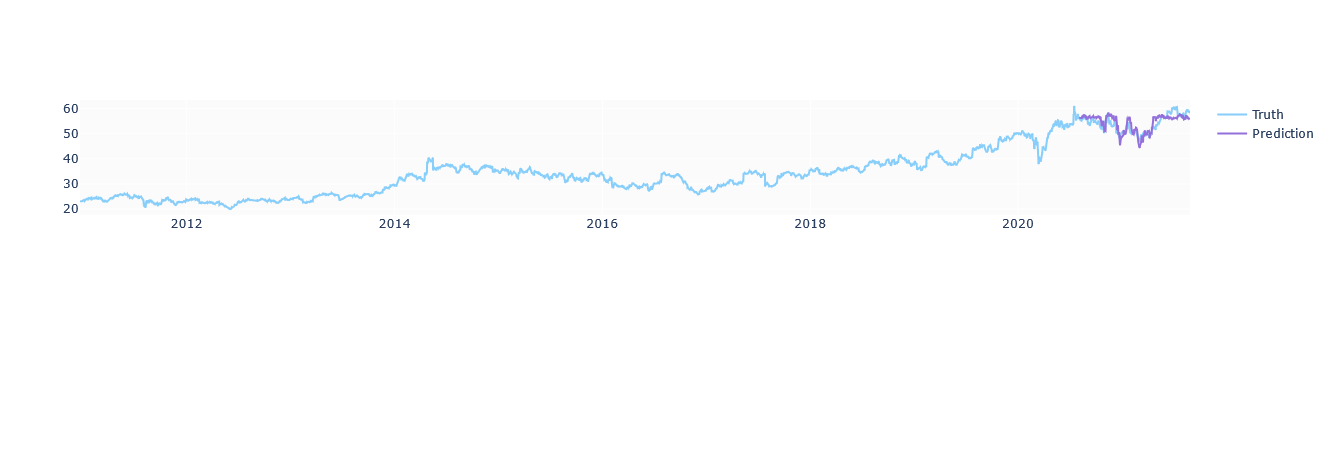

In [22]:
plot_predictions(predicted_prices, azn_df, 'Close')

In [23]:
### Trying LSTM model

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model_1 = Sequential()

number_units = 50
dropout_fraction = 0.1

# Layer 1
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (x_train.shape[1],1))
         )
model_1.add(Dropout(dropout_fraction))

# Layer 2
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model_1.add(Dropout(dropout_fraction))

# Layer 3
model_1.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model_1.add(Dropout(dropout_fraction))

model_1.add(Dense(1))

In [24]:
model_1.compile(optimizer="adam", loss="mean_squared_error")
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 13, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 13, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [25]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
242/242 [==============================] - 5s 8ms/step - loss: 0.0029
Epoch 2/50
242/242 [==============================] - 2s 7ms/step - loss: 0.0036
Epoch 3/50
242/242 [==============================] - 2s 7ms/step - loss: 0.0053
Epoch 4/50
242/242 [==============================] - 2s 7ms/step - loss: 0.0073
Epoch 5/50
242/242 [==============================] - 2s 7ms/step - loss: 0.0031
Epoch 6/50
242/242 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 7/50
242/242 [==============================] - 2s 7ms/step - loss: 9.2934e-04
Epoch 8/50
242/242 [==============================] - 2s 7ms/step - loss: 9.8790e-04
Epoch 9/50
242/242 [==============================] - 2s 7ms/step - loss: 0.0014
Epoch 10/50
242/242 [==============================] - 2s 8ms/step - loss: 0.0011
Epoch 11/50
242/242 [==============================] - 2s 7ms/step - loss: 9.9621e-04
Epoch 12/50
242/242 [==============================] - 2s 7ms/step - loss: 9.7182e-04
Epoch 13/

In [26]:
model_1.evaluate(x_test, y_test)

9/9 [==============================] - 1s 5ms/step - loss: 0.0074


0.0074361166916787624

In [27]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')
predicted_prices = azn_df.loc[df_test.index[0]:].copy()
predicted_prices['Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

mean_squared_error = 0.007436116958563263


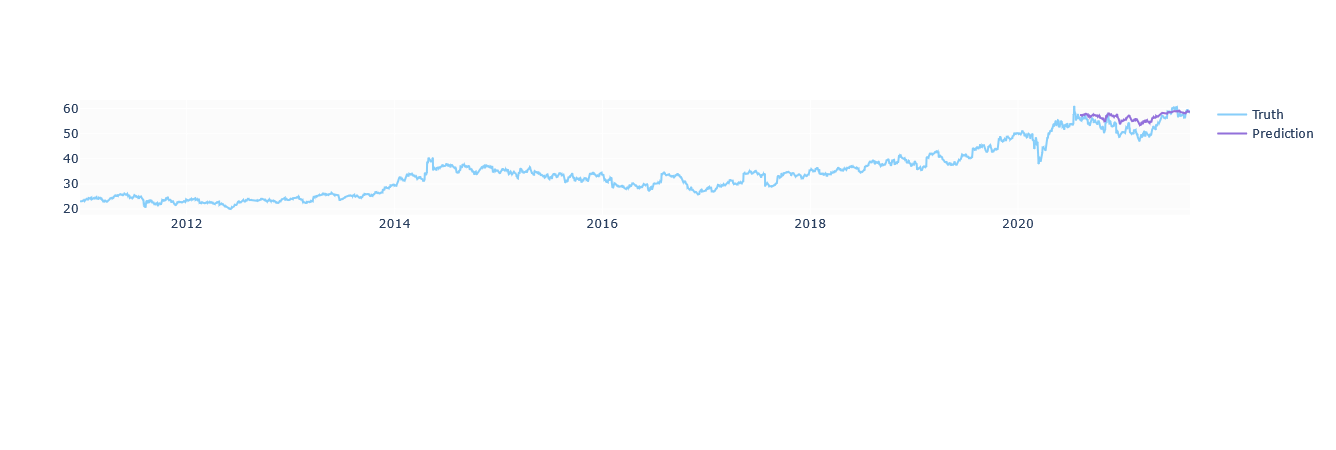

In [28]:
plot_predictions(predicted_prices, azn_df, 'Close')

In [29]:
##### Trying to predict High Prices for Range

In [30]:
azn_df = pd.read_csv('AZN_stock_prices.csv', index_col='Date', parse_dates=True)

In [31]:
azn_df[['High', 'Low']] = azn_df[['High', 'Low']].shift(-1)
azn_df.head()

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2010-01-04  23.709999  23.465000  23.150000  23.705000  13.959425  2606200
2010-01-05  23.434999  23.045000  22.785000  23.225000  13.676762  2666600
2010-01-06  22.915001  23.325001  23.120001  23.040001  13.567821  3020800
2010-01-07  23.250000  23.415001  23.174999  23.290001  13.715042  4454600
2010-01-08  23.270000  23.915001  23.690001  23.389999  13.773925  2675600

In [32]:
azn_df.tail()

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-08-24  58.360001  58.950001  58.400002  58.520000  58.520000  4234000
2021-08-25  58.939999  59.060001  58.430000  58.580002  58.580002  5606800
2021-08-26  58.860001  59.230000  58.459999  58.759998  58.759998  3715400
2021-08-27  58.889999  58.805000  58.514999  58.630001  58.630001  5244600
2021-08-30  58.669998        NaN        NaN  58.610001  58.610001  2296705

In [33]:
azn_df = azn_df[:-1]

In [34]:
azn_df.tail()

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-08-23  59.090000  58.570000  57.860001  58.799999  58.799999  6114700
2021-08-24  58.360001  58.950001  58.400002  58.520000  58.520000  4234000
2021-08-25  58.939999  59.060001  58.430000  58.580002  58.580002  5606800
2021-08-26  58.860001  59.230000  58.459999  58.759998  58.759998  3715400
2021-08-27  58.889999  58.805000  58.514999  58.630001  58.630001  5244600

In [35]:
df_train, df_test = train_test_split(azn_df, train_size=0.9, shuffle=False)

In [36]:
x_train = df_train.drop('High', axis=1)
y_train = df_train[['High']]
x_test = df_test.drop('High', axis=1)
y_test = df_test[['High']]

In [37]:
# Preprocessing

scaler_1 = MinMaxScaler()

scaler_1.fit(x_train)
x_train = scaler_1.transform(x_train)
x_test = scaler_1.transform(x_test)

scaler_1.fit(y_train)
y_train = scaler_1.transform(y_train)
y_test = scaler_1.transform(y_test)

In [38]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model_2 = Sequential()

number_units = 50
dropout_fraction = 0.1

# Layer 1
model_2.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (x_train.shape[1],1))
         )
model_2.add(Dropout(dropout_fraction))

# Layer 2
model_2.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model_2.add(Dropout(dropout_fraction))

# Layer 3
model_2.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model_2.add(Dropout(dropout_fraction))

model_2.add(Dense(1))

In [39]:
model_2.compile(optimizer="adam", loss="mean_squared_error")
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [40]:
epochs = 50
batch_size = 10
model_2.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
264/264 [==============================] - 4s 4ms/step - loss: 0.0030
Epoch 2/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0031
Epoch 3/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0026
Epoch 4/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0013
Epoch 5/50
264/264 [==============================] - 1s 4ms/step - loss: 6.4307e-04
Epoch 6/50
264/264 [==============================] - 1s 4ms/step - loss: 5.9540e-04
Epoch 7/50
264/264 [==============================] - 1s 4ms/step - loss: 8.8095e-04
Epoch 8/50
264/264 [==============================] - 1s 4ms/step - loss: 7.3390e-04
Epoch 9/50
264/264 [==============================] - 1s 4ms/step - loss: 6.1968e-04
Epoch 10/50
264/264 [==============================] - 1s 4ms/step - loss: 6.4341e-04
Epoch 11/50
264/264 [==============================] - 1s 4ms/step - loss: 8.1172e-04
Epoch 12/50
264/264 [==============================] - 1s 4ms/step - loss: 5.80

In [41]:
model_2.evaluate(x_test, y_test)

10/10 [==============================] - 1s 3ms/step - loss: 0.0037


0.003667026525363326

In [42]:
y_pred_high = model_2.predict(x_test)

In [43]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred_high)}')
predicted_prices = azn_df.loc[df_test.index[0]:].copy()
predicted_prices['High'] = scaler_1.inverse_transform(y_pred_high.reshape(-1,1))

mean_squared_error = 0.003667026416168339


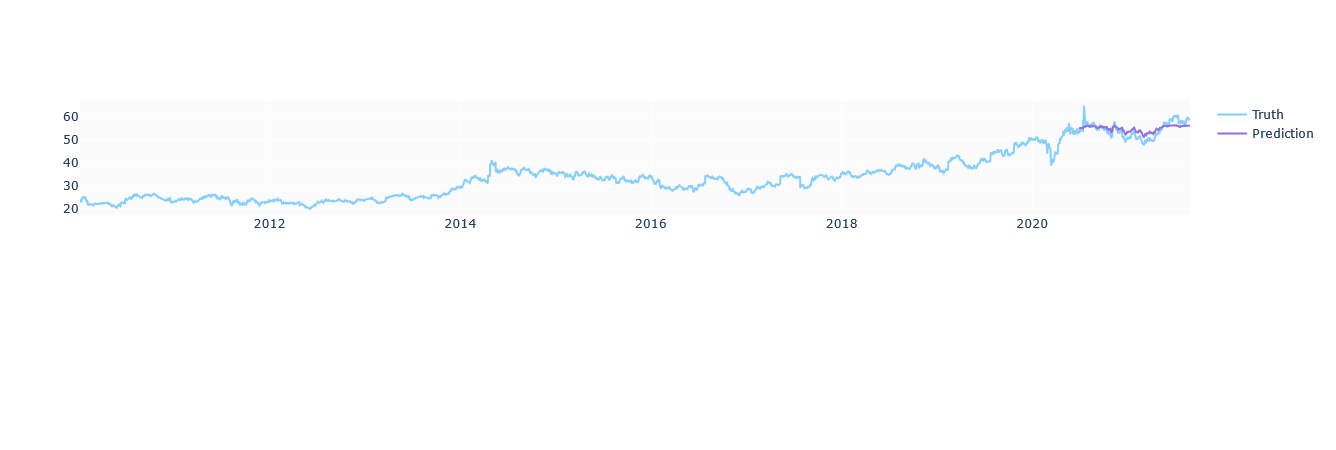

In [44]:
plot_predictions(predicted_prices, azn_df, 'High')

In [45]:
############# Trying to predict the Low price

In [46]:
x_train = df_train.drop('Low', axis=1)
y_train = df_train[['Low']]
x_test = df_test.drop('Low', axis=1)
y_test = df_test[['Low']]

In [47]:
# Preprocessing

scaler_2 = MinMaxScaler()

scaler_2.fit(x_train)
x_train = scaler_2.transform(x_train)
x_test = scaler_2.transform(x_test)

scaler_2.fit(y_train)
y_train = scaler_2.transform(y_train)
y_test = scaler_2.transform(y_test)

In [48]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model_2 = Sequential()

number_units = 50
dropout_fraction = 0.1

# Layer 1
model_2.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (x_train.shape[1],1))
         )
model_2.add(Dropout(dropout_fraction))

# Layer 2
model_2.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model_2.add(Dropout(dropout_fraction))

# Layer 3
model_2.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model_2.add(Dropout(dropout_fraction))

model_2.add(Dense(1))

In [49]:
model_2.compile(optimizer="adam", loss="mean_squared_error")
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [50]:
epochs = 50
batch_size = 10
model_2.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
264/264 [==============================] - 4s 4ms/step - loss: 0.0038
Epoch 2/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0027
Epoch 3/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 4/50
264/264 [==============================] - 1s 4ms/step - loss: 8.7966e-04
Epoch 5/50
264/264 [==============================] - 1s 4ms/step - loss: 7.8791e-04
Epoch 6/50
264/264 [==============================] - 1s 4ms/step - loss: 7.9263e-04
Epoch 7/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 8/50
264/264 [==============================] - 1s 4ms/step - loss: 0.0010
Epoch 9/50
264/264 [==============================] - 1s 4ms/step - loss: 6.3494e-04
Epoch 10/50
264/264 [==============================] - 1s 4ms/step - loss: 6.8628e-04
Epoch 11/50
264/264 [==============================] - 1s 4ms/step - loss: 8.7852e-04
Epoch 12/50
264/264 [==============================] - 1s 4ms/step - loss: 9.5643e-

In [51]:
model_2.evaluate(x_test, y_test)

10/10 [==============================] - 1s 2ms/step - loss: 0.0053


0.0053305961191654205

In [52]:
y_pred_low = model_2.predict(x_test)

In [53]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred_high)}')
predicted_prices = azn_df.loc[df_test.index[0]:].copy()
predicted_prices['Low'] = scaler_2.inverse_transform(y_pred_low.reshape(-1,1))

mean_squared_error = 0.0055031324288540425


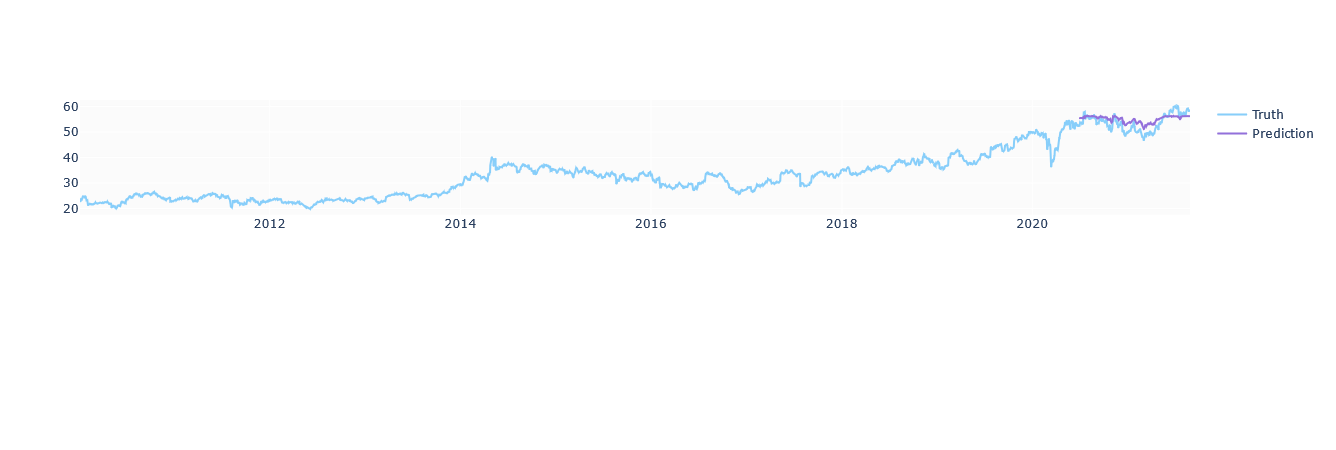

In [54]:
plot_predictions(predicted_prices, azn_df, 'Low')